In [1]:
from fdfdpy import Simulation
import time

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
omega = 5e14                # angular frequency (2pi)
dl = 0.04                   # grid size L0
eps_r = np.ones((100,100))  # relative permittivity
eps_m = 5
eps_r[40:60, 40:60] = eps_m # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [8]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Simulation(omega,eps_r,dl,NPML,pol)

In [9]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 110
simulation.src = b
(Hx,Hy,Ez) = simulation.solve_fields()

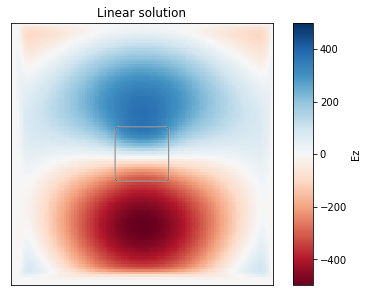

In [10]:
# plot
simulation.plt_re()
plt.title('Linear solution')
plt.show()

In [14]:
chi3 = 2.8*1e-18         # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2        # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
nl_region = np.zeros(eps_r.shape)  # Nonliearity region
nl_region[40:60, 40:60] = 1
def kerr_nonlinearity(e, eps_r):
    return 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))
def kerr_nl_de(e, eps_r):
    return 3*chi3/np.square(simulation.L0)*np.conj(e)

the simulation did not converge, reached 8.532136325477661e-07
3.4540395736694336


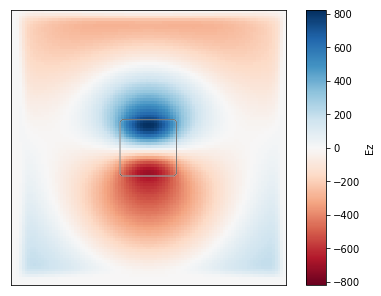

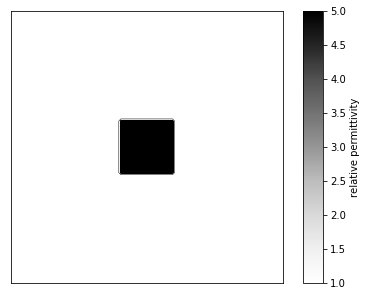

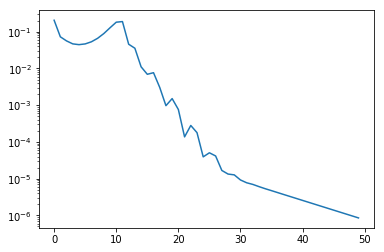

In [15]:
# Do a born solve for the nonlinear fields
# solve the nonlinear fields.
simulation_nl = Simulation(omega, eps_r, dl, NPML, pol)
simulation_nl.src = b
start = time.time()
(Hx_nl, Hy_nl, Ez_nl_B, convergence) = simulation_nl.solve_fields_nl(kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=False,
                                          Estart=None, solver_nl='born', max_num_iter=50)
print(time.time()-start)

# plot results
simulation_nl.plt_re()
simulation_nl.plt_eps()
plt.show()
plt.plot(convergence)
plt.yscale('log')

2.510798692703247


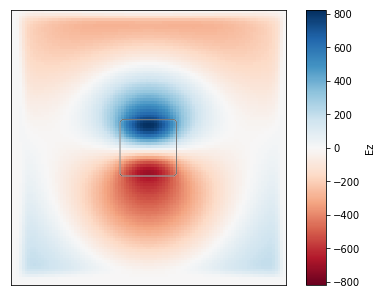

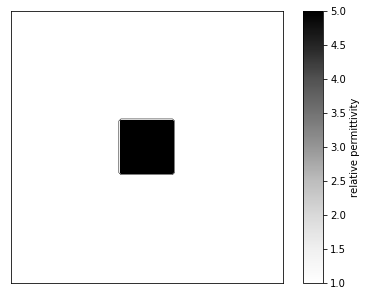

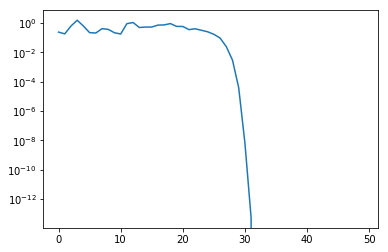

In [34]:
# Do a newton solve for the nonlinear fields
simulation_nl = Simulation(omega, eps_r, dl, NPML, pol)
simulation_nl.src = b
start = time.time()
(Hx_nl, Hy_nl, Ez_nl_N, convergence) = simulation_nl.solve_fields_nl(kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=False,
                                          Estart=None, solver_nl='newton', max_num_iter=50)
print(time.time()-start)

# plot results
simulation_nl.plt_re()
simulation_nl.plt_eps()
plt.show()
plt.plot(convergence)
plt.yscale('log')

In [9]:
print(np.linalg.norm(Ez_nl_B - Ez_nl_N))

0.19390863452284546


In [ ]:
# And finally a Levenberg-Marquard solve
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
simulation_nl.src = b
start = time.time()
(Hx_nl, Hy_nl, Ez_nl_LM, convergence) = simulation_nl.solve_fields_nl(kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=False,
                                          Estart=None, solver_nl='LM', max_num_iter=50)
print(time.time()-start)

# plot results
simulation_nl.plt_re()
simulation_nl.plt_eps()
plt.show()
plt.plot(convergence)
plt.yscale('log')

21594.033608440775


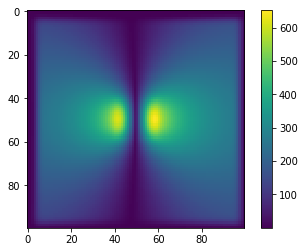

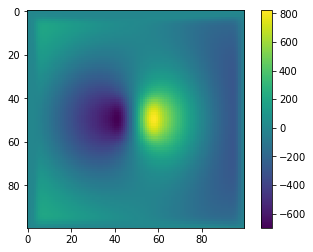

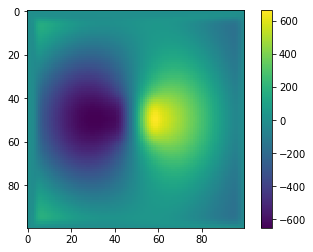

In [38]:
print(np.linalg.norm(Ez_nl_N - Ez_nl_LM))
plt.imshow((np.abs(Ez_nl_N - Ez_nl_LM)))
plt.colorbar()
plt.show()
plt.imshow((np.real(Ez_nl_N)))
plt.colorbar()
plt.show()
plt.imshow((np.real(Ez_nl_LM)))
plt.colorbar()
plt.show()

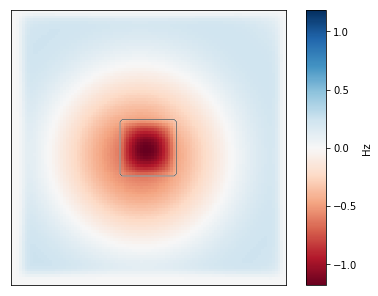

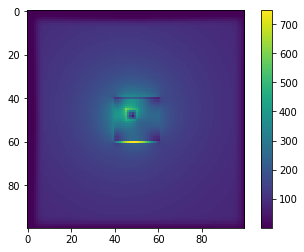

In [33]:
# Now try Hz
pol = 'Hz'              
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
# Taking source power such that the E-field intensity is comparable to the Ez-case above
# Also putting it in the material because otherwise the E-field is pretty small
b[45:50, 45:50] = 7000   
simulation.src = b
(Ex_l,Ey_l,Hz_l) = simulation.solve_fields()
# plot results
simulation.plt_re()
plt.show()
plt.imshow(np.sqrt(np.square(np.abs(Ex_l)) + np.square(np.abs(Ey_l))).T)
plt.colorbar()
plt.show()

1.984285831451416


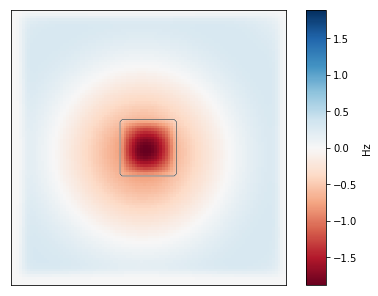

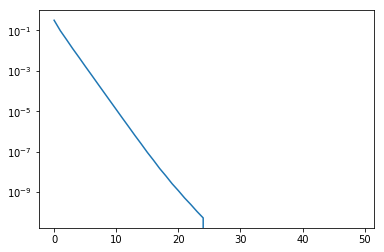

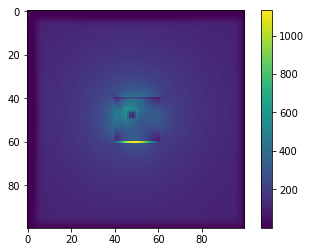

In [34]:
# Do a born solve for the nonlinear fields
# solve the nonlinear fields.
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
simulation_nl.src = b
start = time.time()
(Ex_nl_B, Ey_nl_B, Hz_nl_B, convergence) = simulation_nl.solve_fields_nl(kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=True,
                                          Estart=None, solver_nl='born', max_num_iter=50)
print(time.time()-start)

# plot results
simulation_nl.plt_re()
plt.show()
plt.plot(convergence)
plt.yscale('log')
plt.show()
plt.imshow(np.sqrt(np.square(np.abs(Ex_nl_B)) + np.square(np.abs(Ey_nl_B))).T)
plt.colorbar()
plt.show()

3.350977897644043


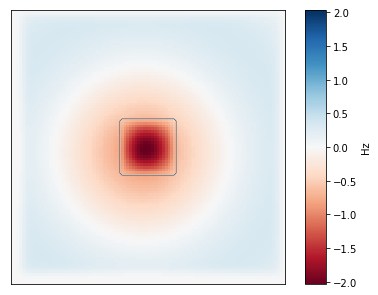

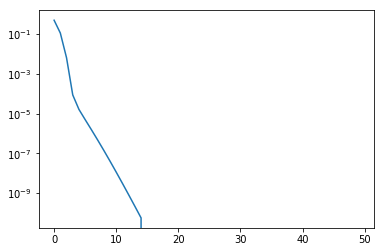

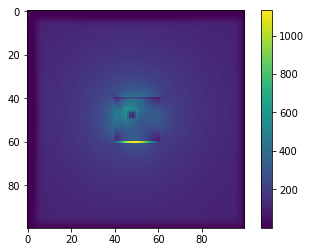

In [35]:
# Do a newton solve for the nonlinear fields
# solve the nonlinear fields.
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
simulation_nl.src = b
start = time.time()
(Ex_nl_N, Ey_nl_N, Hz_nl_N, convergence) = simulation_nl.solve_fields_nl(kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=True,
                                          Estart=None, solver_nl='newton', max_num_iter=50)
print(time.time()-start)
# plot results
simulation_nl.plt_re()
plt.show()
plt.plot(convergence)
plt.yscale('log')
plt.show()
plt.imshow(np.sqrt(np.square(np.abs(Ex_nl_B)) + np.square(np.abs(Ey_nl_B))).T)
plt.colorbar()
plt.show()

In [36]:
print(np.max(np.abs(Ey_nl_B - Ey_nl_N)))

111.85224427488752


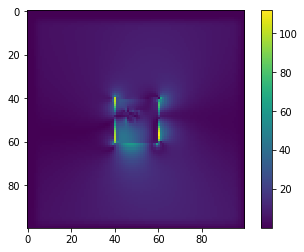

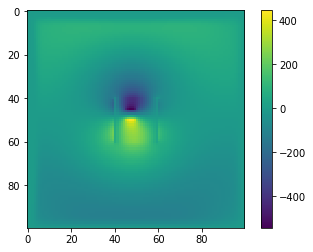

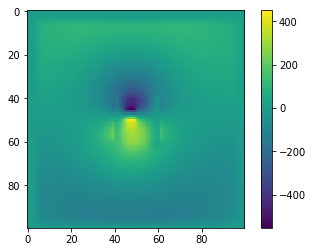

In [37]:
plt.imshow((np.abs(Ey_nl_B - Ey_nl_N)))
plt.colorbar()
plt.show()
plt.imshow((np.real(Ey_nl_B)))
plt.colorbar()
plt.show()
plt.imshow((np.real(Ey_nl_N)))
plt.colorbar()
plt.show()